In [1]:
!pip3 torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

ERROR: unknown command "torch===1.7.1+cu110"



In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

^C


Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.7 GB 11.7 MB/s eta 0:03:51
     ---------------------------------------- 0.0/2.7 GB 16.0 MB/s eta 0:02:48
     ---------------------------------------- 0.0/2.7 GB 15.9 MB/s eta 0:02:50
     ---------------------------------------- 0.0/2.7 GB 16.4 MB/s eta 0:02:44
     ---------------------------------------- 0.0/2.7 GB 16.8 MB/s eta 0:02:40
     ---------------------------------------- 0.0/2.7 GB 16.6 MB/s eta 0:02:42
     ---------------------------------------- 0.0/2.7 GB 16.2 MB/s eta 0:02:45
     ---------------------------------------- 0.0/2.7 GB 16.6 MB/s eta 0:02:41
     ---------------------------------------- 0.0/2.7 GB 16.8 MB/s eta 0:02:39
      --------------------------------------- 0.0/2.7 GB 16.7 MB/s eta 0:02:40
      --------------------------------------- 0.0/2.7 GB 16.2 MB/s eta 0:02:45
 

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [68]:
from transformers import pipeline 
from nltk import sent_tokenize
import nltk
import torch 
from glob import glob
import pandas as pd
import numpy as np

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zingi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
## Load Model. 
model_name = 'facebook/bart-large-mnli' 
device = 0 if torch.cuda.is_available() else 'cpu'
print(device)

0


In [7]:
def load_model(model):

    theme_classifier = pipeline(
        'zero-shot-classification',
        model=model_name,
        device=device
    )

    return theme_classifier

In [11]:
theme_classifier = load_model(device)

c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
theme_list = ['friendship', 'hope', 'sacrifice', 'battle', 'self development', 'betrayal', 'love', 'dialogue']

In [13]:
theme_classifier(
    'I gave him a right hook then a left jab to the face.',
    theme_list,
    multi_label=True
)

c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'sequence': 'I gave him a right hook then a left jab to the face.',
 'labels': ['battle',
  'self development',
  'sacrifice',
  'hope',
  'betrayal',
  'dialogue',
  'love',
  'friendship'],
 'scores': [0.8030523657798767,
  0.4697459042072296,
  0.06129888817667961,
  0.04217679053544998,
  0.024995071813464165,
  0.00991175789386034,
  0.002317106584087014,
  0.00023018485808279365]}

In [17]:
## Load dataset.
files = glob('../data/naruto_s1_subtitles/*.ass')

files[:5]

['../data/naruto_s1_subtitles\\Naruto Season 1 - 01.ass',
 '../data/naruto_s1_subtitles\\Naruto Season 1 - 02.ass',
 '../data/naruto_s1_subtitles\\Naruto Season 1 - 03.ass',
 '../data/naruto_s1_subtitles\\Naruto Season 1 - 04.ass',
 '../data/naruto_s1_subtitles\\Naruto Season 1 - 05.ass']

In [21]:
with open(files[0], 'r') as sub_file:
    lines = sub_file.readlines()
    lines = lines[27:]
    lines = [','.join(line.split(',')[9:]) for line in lines]

In [22]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [29]:
lines = [ line.replace('\n', ' ')  for line in lines ]

lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails. ',
 'With its powerful tails, ']

In [30]:
' '.join( lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.  With its powerful tails,  it could smash mountains and create tidal waves.  A band of Ninjas rose to defend their village from attack.  We have to wait until the Fourth Hokage gets here!  We can't let it get any closer to our village!  One great Ninja was able to imprison the monster,  but died in the process.  This Ninja was known as… the Fourth Hokage.  Naruto! "

In [43]:
episode_no = int(files[0].split('-')[-1].split('.')[0].strip())
print(episode_no)

1


In [53]:
def load_subtitles_dataset(dataset_path):

    '''
        Load dataset and clean directory filenames to extract meaningful data. 
    '''

    scripts = []
    episodes = []

    subs_path = glob(dataset_path+'/*.ass')

    for path in subs_path:

        with open(files[0], 'r') as sub_file:
            lines = sub_file.readlines()
            lines = lines[27:]
            lines = [','.join(line.split(',')[9:]) for line in lines]

        lines = [ line.replace('\\N', ' ')  for line in lines ]
        script = ' '.join(lines)

        episode_no = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episodes.append(episode_no)

    episodes_df = pd.DataFrame.from_dict({'episode:':episodes, 'script':scripts})

    return episodes_df
    

In [55]:
dataset_path = '../data/naruto_s1_subtitles'

episodes_df = load_subtitles_dataset(dataset_path=dataset_path)

episodes_df.head()

,episode:,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"A long time ago, a powerful demon fox appeared..."
2,3,"A long time ago, a powerful demon fox appeared..."
3,4,"A long time ago, a powerful demon fox appeared..."
4,5,"A long time ago, a powerful demon fox appeared..."


In [56]:
script = episodes_df.iloc[0]['script']
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [57]:
## Script is very long, need it broken down into seperate sentences to avoid overwhelming the model. Like batches. 
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [61]:
senetence_batch_size = 20 
script_batches = []

for index in range(0, len(script_sentences), senetence_batch_size):

    sentence = ' '.join(script_sentences[index:index+senetence_batch_size])
    script_batches.append(sentence)

script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [63]:
theme_output = theme_classifier(
    script_batches[:2], 
    theme_list,
    multi_label=True
)

theme_output

c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x00000239A635E880> was reported to be 2(when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x00000239A635E880> was reported to be 2(when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x00000239A635E880> was reported to be 2(when accessing len(dataloader)), but 5 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\z

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.9800739288330078,
   0.9396895170211792,
   0.8546879887580872,
   0.734980583190918,
   0.7284932136535645,
   0.1990982741117477

In [64]:
## Wrangle output. 

themes = {}

for output in theme_output:

    for label, score in zip(output['labels'], output['scores']):

        if label not in themes:
            themes[label] = []

        themes[label].append(score)

themes

{'dialogue': [0.9800739288330078, 0.9370121359825134],
 'betrayal': [0.9396895170211792, 0.645724892616272],
 'battle': [0.8546879887580872, 0.658130943775177],
 'sacrifice': [0.734980583190918, 0.6258822679519653],
 'self development': [0.7284932136535645, 0.8678199052810669],
 'hope': [0.19909827411174774, 0.20424039661884308],
 'friendship': [0.05922282114624977, 0.0860329270362854],
 'love': [0.04026174172759056, 0.028020812198519707]}

In [71]:
def get_themes_inference(script):

    ''' '''

    batch_size = 20

    script_batches = []

    ''' Process the sentences into batches. '''

    script_sentences = sent_tokenize(script)

    for index in range(0, len(script_sentences),batch_size):

        sentence = ' '.join(script_sentences[index:index+batch_size])
        script_batches.append(sentence)
    
    ''' Run model on the processed, batched data. '''

    theme_output = theme_classifier(
        script_batches[:2], 
        theme_list, 
        multi_label=True
    )

    ''' Create meaningful output. '''

    themes = {}

    for output in theme_output:

        for label, score in zip(output['labels'], output['scores']):

            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    mean_themes = { key: np.mean(np.array(theme)) for key, theme in themes.items() }

    return mean_themes

In [75]:
output_themes = episodes_df['script'].apply(get_themes_inference)

c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x00000239E852B6D0> was reported to be 2(when accessing len(dataloader)), but 3 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x00000239E852B6D0> was reported to be 2(when accessing len(dataloader)), but 4 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\zingi\anaconda3\envs\nlpwgpu\lib\site-packages\torch\utils\data\dataloader.py:641: UserWarning: Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x00000239E852B6D0> was reported to be 2(when accessing len(dataloader)), but 5 samples have been fetched. 
  warnings.warn(warn_msg)
c:\Users\z

In [76]:
output_themes

0    {'dialogue': 0.9585430324077606, 'betrayal': 0...
1    {'dialogue': 0.9585430324077606, 'betrayal': 0...
Name: script, dtype: object

In [79]:
themes_df = pd.DataFrame(output_themes.tolist())
themes_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.958543,0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141
1,0.958543,0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141


In [100]:
episodes_df[themes_df.columns] = themes_df
episodes_df

,episode:,script,betrayal,battle,sacrifice,self development,hope,friendship,love,dialogue
0,1,"A long time ago, a powerful demon fox appeared...",0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141,0.958543
1,2,"A long time ago, a powerful demon fox appeared...",0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141,0.958543


In [101]:
episodes_df

,episode:,script,betrayal,battle,sacrifice,self development,hope,friendship,love,dialogue
0,1,"A long time ago, a powerful demon fox appeared...",0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141,0.958543
1,2,"A long time ago, a powerful demon fox appeared...",0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141,0.958543


In [108]:
### Visualise output. 
#episodes_df = episodes_df.drop(['episode:', 'script', 'dialogue'], axis=1)
theme_output = episodes_df.sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,1.585414
1,battle,1.512819
2,sacrifice,1.360863
3,self development,1.596313
4,hope,0.403339
5,friendship,0.145256
6,love,0.068283


In [110]:
import matplotlib.pyplot as plt 
import seaborn as sns 

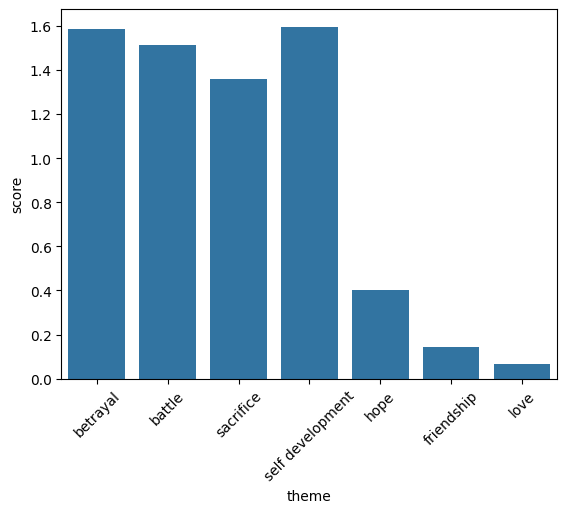

In [112]:
sns.barplot(
    data=theme_output, 
    x='theme', 
    y='score'
)

plt.xticks(rotation=45)
plt.show()

In [ ]:
'''friendship, hope, sacrifice, battle, self, development, betrayal, love

C:/general_programming/python/nlp/nlp_fake_netflix/data/naruto_s1_subtitles

C:/general_programming/python/nlp/nlp_fake_netflix/stubs/output.csv

2:20'''